In [ ]:
!pip install mario_gpt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from pprint import pprint
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler
from mario_gpt.utils import convert_level_to_png
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
import numpy as np

import os
import time
import datetime
import re

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

import zipfile

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

from PIL import Image
from IPython.display import display

import tensorflow as tf

seed_val = 99

# 1e experiment: seed_val = 42
# 2e experiment: seed_val = 84
# 3e experiment: seed_val = 168
# 4e experiment: seed_val = 21
# 5e experiment: seed_val = 10
# 6e experiment: seed_val = 15
# 7e experiment: seed_val = 20
# 8e experiment: seed_val = 25
# 9e experiment: seed_val = 30
# 10e experiment: seed_val = 99



random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

if torch.cuda.is_available():
    print('GPU found')
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(seed_val)
else:
    print('No GPU found. Switching to CPU.')
    device = torch.device('cpu')
    torch.manual_seed(seed_val)


os.environ['WANDB_DISABLED'] = 'true'

from huggingface_hub import interpreter_login

interpreter_login(new_session=False)

GPU found
User is already logged in.


In [ ]:
##### CHOOSE BOTTOM-UP OR SNAKING #####
# representation = 'bottom-up'
representation = 'snaking'

##### CHOOSE WITH OR WITHOUT PATH INFORMATION #####
path_information = True
# path_information = False

##### CHOOSE WITH OR WITHOUT COLUMN NUMBER #####
column_number = True
# column_number = False

In [ ]:
def add_column_number(txt_list):
    levels_concatenated = []

    for x in txt_list.values():
        special_char = 0
        join_count = 0
        result_string = ''
        for element in x:
            result_string += element
            join_count += 1
            if join_count != len(x):
                result_string += f'{special_char}'
            if join_count % 5 == 0 and join_count != len(x):
                special_char += 1
        levels_concatenated.append(result_string)

    return levels_concatenated

In [ ]:
folder_paths_without_path_info = ['drive/MyDrive/without_paths_levels1',
                                  'drive/MyDrive/without_paths_levels2']

folder_paths_with_path_info = ['drive/MyDrive/with_paths_levels1',
                               'drive/MyDrive/with_paths_levels2']

if path_information == True:
  folder_paths = folder_paths_with_path_info

elif path_information == False:
  folder_paths = folder_paths_without_path_info

levels_normal = {}
levels_bottom_up = {}
levels_snaking = {}

for folder_path in folder_paths:
    files = os.listdir(folder_path)
    for file_name in files:
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)

            with open(file_path, 'r') as file:
                file_content = file.read()

                lines = file_content.split('\n')
                lines = [line.rstrip() for line in lines if line.strip()]

                levels_normal[file_name] = lines

                lines = [line for line in lines if line.strip()]
                snaking_lines = list(lines)

                snaking_lines.reverse()
                transposed_snaking_lines = [''.join(row) for row in zip(*snaking_lines)]

                transposed_snaking_lines_copy = transposed_snaking_lines.copy()

                for i in range(len(transposed_snaking_lines)):
                    if i % 2 == 1:
                        transposed_snaking_lines[i] = transposed_snaking_lines[i][::-1]

                for i in range(len(transposed_snaking_lines_copy)):
                    if i % 2 == 0:
                        transposed_snaking_lines_copy[i] = transposed_snaking_lines_copy[i][::-1]

                lines.reverse()
                transposed_lines = [''.join(row) for row in zip(*lines)]

                levels_bottom_up[file_name] = transposed_lines
                levels_snaking[file_name] = transposed_snaking_lines
                levels_snaking[f'{file_name}(2)'] = transposed_snaking_lines_copy

In [ ]:
if representation == 'snaking':
  levels = levels_snaking
elif representation == 'bottom-up':
  levels = levels_bottom_up

In [ ]:
len(levels)

74

In [ ]:
model = AutoModelForCausalLM.from_pretrained("distilbert/distilgpt2")
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilgpt2", bos_token='|startoftext|', eos_token='|endoftext|')

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, max_length=512): # max_length = origineel 768

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    if column_number == True:
      levels_concatinated = add_column_number(txt_list)

    elif column_number == False:
      levels_concatinated = ["=".join(x) for x in txt_list.values()]

    # display(convert_level_to_png(bottom_up_to_standard(level))[0])

    for txt in levels_concatinated:

      encodings_dict = tokenizer(txt, truncation=True, max_length=max_length, padding="max_length")

      # '<|startoftext|>'+ txt + '<|endoftext|>'

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))


  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [ ]:
train = GPT2Dataset(levels, tokenizer=tokenizer)

# Split into training and validation sets
train_size = int(0.9 * len(train))
val_size = len(train) - train_size

train_dataset, val_dataset = random_split(train, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

   66 training samples
    8 validation samples


In [ ]:
train_dataloader = DataLoader(
            train,  # The training samples.
            sampler = RandomSampler(train), # Select batches randomly
            batch_size = 4 # Trains with this batch size.
        )


validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = 4 # Evaluate with this batch size.
        )

In [ ]:
model.resize_token_embeddings(len(tokenizer))

model.to(device)

epochs = 20
learning_rate = 5e-3
# 5e-2 output junk
warmup_steps = 1e2
epsilon = 1e-9

# this produces sample output every 100 steps
sample_every = 18

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon,
                  weight_decay=0.01
                )

In [ ]:
# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

if column_number == True:
  s = '0'
elif column_number == False:
  s = '='

if representation =='snaking':
  prompt = f'X-------------{s}-------------X{s}X-------------{s}------------X'

elif representation == 'bottom-up':
  prompt = f'X-------------{s}X-------------{s}X-------------{s}X------------'

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    generated,
                                    # bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )

            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 3.046837091445923.   Elapsed: 0:00:07.
0: X-------------0-------------X0X-------------0------------XX0------------0------------4------------6------------4------------xxx---4----x-----------Xx------------xX6------------x---x------------6------------X6-------------xXxxxXXxx------------x---------x------------x--XXx--xXx------------xXXXXXXXXx------------x------------x------------xXX---------x------------x------------xXxx------------x------------xXXXXXX------------x------------x---------x------------x------------x------------x---------x-----------x---x------------x------------x--x--------------x-------xXXXx-----x------x------------x---------xXx-----------x------------x------------x---xXX-----------xXXXx------------x------------x------x------x------x-------x------------x------x------------x------x--------x--------------x---x------x------------x-----x-----xx------x----x--------x------------x------

  Average training loss: 3.80
  Training epoch took: 0:00:08

R

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 2.6488778591156006.   Elapsed: 0:00:07.
0: X-------------0-------------X0X-------------0------------X0-------------0xX0XxX2------------0------------0X2X2X3-------------0X3------------x-------------3X3------------xXx-X4------------xx------------5------------6------------xXxX6X6XxXoXx------------5Xx------------6------------x------------6X6X6Xx------------6X6------------6X6------------6------------6Xx------------6------------7Xx------------7------------7X7Xx------------7X7X7------------8------------7X7------------8X8------------8X8Xx------------8------------8------------8------------8Xx------------xX8------------8X8------------Xx------------9------------x------------9------------9------------10------------x------------10------------x------------10------------x------------11------------11------------x------------11------------x------------x------------11------------12X11------------12------------12------------12------------

  Average training loss: 2.61
  T

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 2.226836681365967.   Elapsed: 0:00:07.
0: X-------------0-------------X0X-------------0------------X1---------1---------2---------xx---------3---------xx--2---------X3---------S---------3---------S---------3---------3---------3--XXx---------3---------S------3---------S--3--------x---S-----3---------x----------3--S--3--4------4---------S-----4--------S---------4-----X4------S-----5-----5-----[<<<<<<<<<><>><<>>>>>]]>>>>5--5----S-----5-----S-x------5-----xx-----5-----?--5-----5-----X-----5-----xx-----5---xx------6------6-----o-----6-----X-----6-----X---------6-----x-------6---[[<>-----6-----7-------xx--8---7-------8------X----------8-------x------8-----o------8-----o-----8

  Average training loss: 2.21
  Training epoch took: 0:00:08

Running Validation...
  Validation Loss: 1.98
  Validation took: 0:00:00

======== Epoch 4 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 1.836035966873169.   Elapsed: 0:00:07.
0: X-------------0-------------X0X-------------0------------X0Xx------------1Xx------------1Xx------------1Xx------------1------------xX1------------xX1XXxx-----------2XXx--------2------xX2Xx-----------2------x------2------xX2-----Xx------2------xX3------xXx-----3--Xx--------3XxX-----4Xx------4------x--------4------X-X------4------X------5-----Xx----5------X-Xx----5----xX5----o-------xX-X6-----X-------X-------x----6---X-x----6----X--X-XX6----X-----??--X-------6------X---Xo-------X6-----X-----X-6---X-----X-------8X-----X--X------X---------8-----X-X-------X-------8-----X-X------E

  Average training loss: 1.96
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 1.61
  Validation took: 0:00:00

======== Epoch 5 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 1.5518828630447388.   Elapsed: 0:00:07.
0: X-------------0-------------X0X-------------0------------X0Xx------------1------------xX1Xx------------1------------xX1Xx------------1------------xX1Xx------------2------------xX2Xx--S---------2---------S---------xX3Xx------------3-----------xX3Xx------------4------------xX4Xx------------4Xx------------4------------xX4Xx------------4-----------xX4Xx------------5------------xX5Xx--S---------5------------xX5Xx------------5Xx------------6Xx--X6Xx------------6------------xX6XxX6Xx------------6------------xX6Xx------------6------------xX6Xx---S---------6----------xX6Xx------------6------------xX6Xx------------7------------xX7XxX7Xx------------7------------xX7XxX8Xx-----------8----------xX

  Average training loss: 1.65
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 1.38
  Validation took: 0:00:00

======== Epoch 6 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 1.601768970489502.   Elapsed: 0:00:07.
0: X-------------0-------------X0X-------------0------------X0Xx------------0------------xX1Xx------------1------------xX1Xx------------1------------xX1Xx------------1------------xX1Xx------------1------------xX2Xx------------2------------xX2Xx------------2------------xX2Xx------------2------------xX3Xx------------3------------xX3Xx------------3------------xX3Xx------------4------------xX4Xx------------4------------xX4Xx------------4------------xX5Xx------------5------------xX5Xx------------6------------xX6Xx------------6------------xxX6Xx------------7------------xX7Xxx----------7----------xx-----------8-----------xx---------8---------xx-7---------8---------x---------8---------xx--8-----xx----8-----xx--9---------9---------xx------9-----xx---------10---------xx--10--------xx------10

  Average training loss: 1.52
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 1.19
  Validation took: 0:00:00


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 1.1756467819213867.   Elapsed: 0:00:08.
0: X-------------0-------------X0X-------------0------------X0Xx------------0------------xX1Xx------------1------------xX1Xx------------1------------xX1Xxx-----------2----------xxX2X--xx----------2---------xx--X2X--x---------2---------x---X---------2---------xX---X--------3-------xX-----3-----X-------3------xX----4----X------4----X-------4-------X-------5----X------5-------X-------5-----X---5-------X----6-------X---6----X------6-------X-6----X-------6-------Xx----6-----X-------6-------X--6-------X--6--X--------7----------xxX--7--X---------7---------Xx---------7---------oX---7---X---------8---------X--8---X--8---------X--X------8-----Xx---------8---------X--8---------X-

  Average training loss: 1.29
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 1.03
  Validation took: 0:00:00

======== Epoch 8 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 1.1442351341247559.   Elapsed: 0:00:08.
0: X-------------0-------------X0X-------------0------------X0Xx------------0------------xX1Xx------------1------------xX1Xx------------1-----------xxX-2---Q---Q---Q---xx-----------2---------Q---x----2----Q----xX-----2----Q---xX-----3-----Q------xX-----3-----S----xX-----3-----S-------xX-----3----Q---xX----4----S---Q---Q--xX----4-----Q---?----xX----4----x----4----Xx----X-----5-----S----xX-----5-----S----xxX-----5------xx-----5----x-------5------xx----5-------xx------X------5-------x-------5-------x-------X------6-----x-------X-----6----x-------6-------x-------6-------x-------X-----6-----x-------X-----7-----X-------xx----7

  Average training loss: 1.14
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 0.91
  Validation took: 0:00:00

======== Epoch 9 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 0.7023645639419556.   Elapsed: 0:00:08.
0: X-------------0-------------X0X-------------0------------X0Xxx------------1------------xX1Xx------------1------------xX1Xx------------1-----------xxX2X--xx----------2----------xx--2--xx---------2---------x---2---x--------2--------x---3----Xx--------3--------xxX3----Xxx--------3--------xX3X----x--------3--------x----3----x--------3--------xX4Xx--------4-------xxX-----4-----Xxx-------4--------xx---4-----xx--------4--------x<[[X5X--x--------5--------x>]]X5X[[[X6X]]]>xx--------5--------x-----X6X--x--------6--------xx-X7X-xx--------7--------xx---X7X---xx--------7--------x-----X7X-----xx--------7--------x<[[[X7X]]]>xx--------

  Average training loss: 1.00
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 0.82
  Validation took: 0:00:00

======== Epoch 10 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 0.7449899911880493.   Elapsed: 0:00:08.
0: X-------------0-------------X0X-------------0------------X0Xx------------0------------xX1Xx------------1------------xX1Xx------------1------------xX2Xx------------2------------xX2Xx------------2------------xX3Xx------------3------------xX3Xx------------3------------xX3Xx------------3------------xX3Xx------------4------------xX4Xx------------4------------xX4Xx------------4------------xX5Xx------------5------------xX5Xx------------5------------xX6Xx------------6------------xX6Xx------------6------------xX6Xx------------6------------xX7Xx------------7------------xX7Xx------------7------------xX7Xx------------8------------xX8Xx------------8------------xX8Xx------------8------------xX9Xx------------9------------xX9Xx------------9------------xX9Xx------------9

  Average training loss: 0.89
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 0.71
  Validation took: 0:00:00

======== Epoch 11 / 20 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 0.6735186576843262.   Elapsed: 0:00:07.
0: X-------------0-------------X0X-------------0------------X0Xx------------0------------xX1Xx------------1------------xX1Xx------------1------------xX1Xx------------2------------xX2Xx------------2------------xX2Xx------------2------------xX3Xx------------3------------xX3Xx------------3-----------xxX4<x----------4------------x>]X4XxBb------------4------------xX4<x------------5------------x>5Xx------------5------------xX5Xx------------5------------x<[X6X]]]>x------------6------------xX6Xx------------6------------xX6Xx------------6------------xX7Xx------------7------------xX7Xx------------7------------xX7Xx------------7------------xX7Xx------------8------------xX8Xx------------8------------xX8Xx------------8------------xX9Xx------------9

  Average training loss: 0.81
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 0.66
  Validation took: 0:00:00

======== Epoch 12 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 0.650998055934906.   Elapsed: 0:00:07.
0: X-------------0-------------X0X-------------0------------X0Xx------------0------------xX1Xx------------1------------xX1Xx------------1------------xX1Xxx-----------2----------xx--2---xx----------2---------xx----2----xx--------2--------x----3----x--------3-------xx----3----xx-------X3X-------xx------3-------xx----4----xx------4------Sxx----4----S--x--S------4------S---x--S----4----x--S----5----x-------X5X-------xx----5----x----X5X-------x----5-----x-------X5X-------x----6-----x-------X6X------xx-------6------x----6----xx--------6------x----X7X--------x-----7----x--------7--------x-----X7X---------x----8---x--X8X---------8---------Xxx--8--x

  Average training loss: 0.74
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 0.61
  Validation took: 0:00:00

======== Epoch 13 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 0.4112273156642914.   Elapsed: 0:00:07.
0: X-------------0-------------X0X-------------0------------X0Xx------------0------------xX1Xx------------1------------xX1Xx------------1------------xX1Xxx-----------2----------xx-X2X---xx---------2---------xX---2---Xx---------2---------xX---3---Xx---------3---------xX---3---Xx---------3---------xX---3---Xx---------4---------xX---4---Xx---------4----------xX---4---Xx--Q------4-------Q--xX-5-Xx---Q-----5-----Q---Q--xX-5-Xx--Q---Q-----5-----Q--xX-5-Xx------------5------------xX-6-Xx------------6-----------xxX-6-xx----------7---------Q--xX-7-Xx--Q---------7---------Q--xX-7-Xx------------

  Average training loss: 0.68
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 0.55
  Validation took: 0:00:00

======== Epoch 14 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 0.6342330574989319.   Elapsed: 0:00:07.
0: X-------------0-------------X0X-------------0------------X0Xx------------0------------xX1Xx------------1------------xX1Xx------------1------------xX1Xx------------2------------xX2Xx------------2------------xX2Xx------------2------------xX3Xx------------3------------xX3Xx------------3------------xX3Xx------------4------------xX4Xx------------4------------xX4Xx------------5------------xX5Xx------------5------------xX5Xx------------5------------xX6Xx------------6------------xX6Xx------------6------------xX6Xx------------7------------xX7Xx------------7------------xX7Xx------------7------------xX8Xx------------8------------xX8Xx------------8------------xX8Xx------------8------------xX9Xx------------9------------xX9Xx------------9-----------xxX9--x-----------10

  Average training loss: 0.63
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 0.47
  Validation took: 0:00:00

======== Epoch 15 / 20

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 0.43742430210113525.   Elapsed: 0:00:07.
0: X-------------0-------------X0X-------------0------------X0Xx------------0------------xX1Xx------------1------------xX1Xx------------1------------xX1Xxx-----------2-----------x--2--x-----------2------------xX-2-Xxx-----------2----------xxX-3---Xx----------3----------xxX---3----Xxx---------3--------xxX----3----Xx--------4--------XxX----4----XxXo----4----oXx--Xo----4----oX--xX----4----Xx--Xo----4----oXx--Xo----4----oX--xX----5----Xx--Xo----5----X--xXo----5----Xxo----5----oXxXo----6----oX-----6----Xxo----6----oXxx------7----xx--X-----7-----Xxo

  Average training loss: 0.58
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 0.42
  Validation took: 0:00:00

======== Epoch 16 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 0.45228803157806396.   Elapsed: 0:00:07.
0: X-------------0-------------X0X-------------0------------X0Xx------------0------------xX1Xx------------1------------xX1Xx------------1------------xX1Xx------------2------------xX2Xx------------2------------xX2Xx------------2-----------BxX3Xx------------3------------xX3Xx------------3------------xX3Xx------------4------------xX4Xx------------4------------xX4Xx------------4------------xX4Xx------------5------------xX5Xx------------5------------xX5Xx-E----------5------------xX6Xx------------6------------xX6Xx------------6-----------BxX6Xx------------6------------xX7Xxx-----------7-----------x--7--x-----------7-----------x--7--x-----------8-----------x-X8--x-----------8------------xX8Xx------------8------------xX9Xx------------9------------xX

  Average training loss: 0.51
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 0.36
  Validation took: 0:00:00

======== Epoch 17 / 20 ========
Traini

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 0.45835644006729126.   Elapsed: 0:00:07.
0: X-------------0-------------X0X-------------0------------X0Xx------------0------------xX1Xx------------1------------xX1Xx------------1------------xX1Xxx-----------2----------xx--2---xx---------2--------xX----2----Xx--------3--------xX----3----Xxx--------3-------xx------3------xx------Xo--4--oX--x------4----oX--x----4----oX--xX----4----oX--xX----5----Xx--Xo---5---oX--xXo----5----oX--xX----5----oX--xXo----6----oX--xXo----6----oX--xX----6----oXx--Xo----7----oX-xXo----7----oX-xXo----7----oXx----o---7---oX---x

  Average training loss: 0.46
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 0.33
  Validation took: 0:00:00

======== Epoch 18 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 0.5733520984649658.   Elapsed: 0:00:07.
0: X-------------0-------------X0X-------------0------------X0Xx------------0------------xX1Xx------------1------------xX1Xx------------1---------Q--xX1Xx------------2------------xX2Xx------------2------------xX2Xx------------2------------xX3Xx------------3------------xX3XxbB-----------3------------xX4Xx------------4------------xX4Xx------------4------------xX4Xx------------5------------xX5Xx------------5------------xX5Xx------------6-----Q---xX6Xx--Q-----6-----Q---Q--xX6Xx------------6-----------xxX7--x-----------7-----------x--7--x-----------7-----------x--8Xx------------8------------xX8Xx------------8------------xX8Xxx-----------8-----------x--9--x-----------9-----------x--9--x-----------10------------xX10X

  Average training loss: 0.41
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 0.27
  Validation took: 0:00:00

======== Epoch 19 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 0.4116534888744354.   Elapsed: 0:00:07.
0: X-------------0-------------X0X-------------0------------X0Xx------------0------------xX1Xx------------1------------xX1Xx------------1------------xX1Xxx-----------2-----------x--2--x-----------2-----------xX-2-Xx-----------2-----------xX-3xx----------3---------xx---3----xx--------3--------xX-----3-----Xx--------3--------xX-----4-----Xx--------4-----Xx--------4--------xX-----4-----Xx--------4--------xX-----5-----Xxx--------5--------x----5---X-x-----------5-----------xX-5-Xx-----------5------------xX-6-Xx------------6-----------xxX-6---xx---------6--------xx---6---x---------7---------Xx---7---xxX---------7---------Xx---7---xX---------8---------Xx---8---xX---------8---------Xx---

  Average training loss: 0.37
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 0.23
  Validation took: 0:00:00

======== Epoch 20 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    18  of     19. Loss: 0.2977335453033447.   Elapsed: 0:00:08.
0: X-------------0-------------X0X-------------0------------X0Xx------------0------------xX1Xx------------1------------xX1Xx------------1------------xX1Xx------------2------------xX2Xxx-----------2-----------x--2Xx------------2------------xX3Xx------------3------------xX3Xx------------3------------xX3Xx------------4------------xX4Xx------------4------------xX4Xx------------4------------xX5Xx------------5------------xX5Xx------------5------------xX5Xx------------6------------xX6Xx------------6------------xX6Xx------------6------------xX7Xx------------7------------xX7Xx------------7------------xX7Xx------------8------------xX8Xx------------8------------xX8Xx------------8------------xX9Xx------------9------------xX9Xx------------9------------xX9Xx------------9

  Average training loss: 0.33
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 0.21
  Validation took: 0:00:00

Training complete!
Tota

In [ ]:
# Display floats with two decimal places.
pd.options.display.precision = 2

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

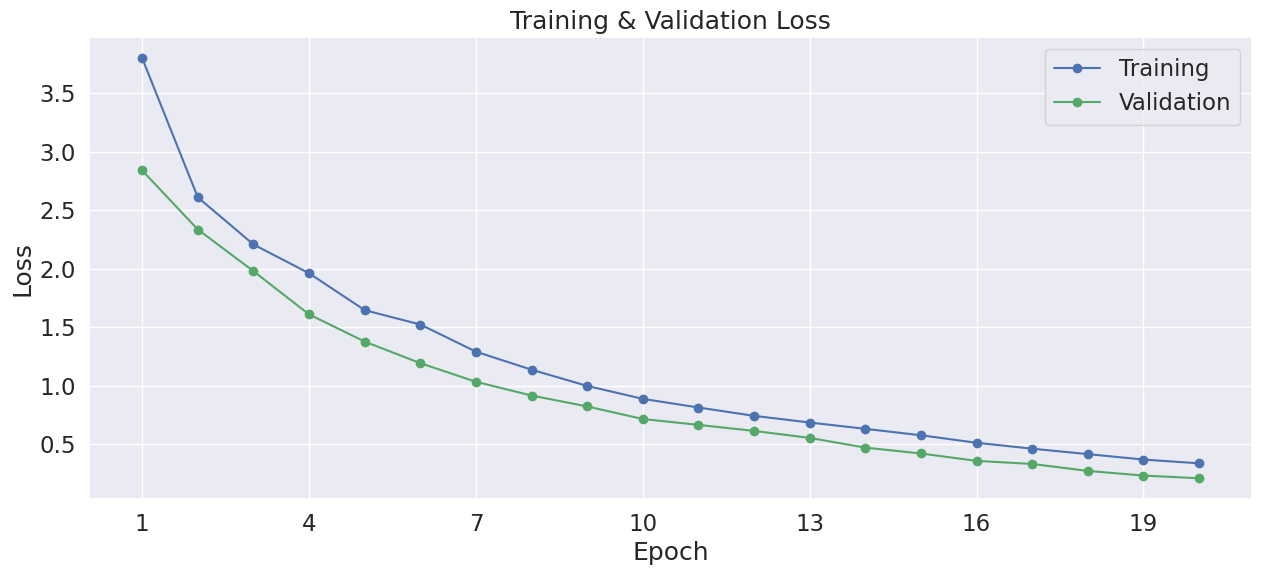

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (15,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(1,epochs,3))

plt.show()

In [ ]:
def snaking_to_standard(level):
    for i in range(len(level)):
        if i % 2 == 1:
            level[i] = level[i][::-1]

    level = [''.join(row) for row in zip(*level)]
    level.reverse()

    return level

In [ ]:
def bottom_up_to_standard(level):
    level = [''.join(row) for row in zip(*level)]
    level.reverse()

    return level

In [ ]:
def remove_close_special_symbols_equals(s):
    special_symbol = '='
    previous_index = -3  # Initialize to a value that's out of range for the first check
    new_string = []  # Using list for efficient string concatenation

    for current_index, char in enumerate(s):
        if char == special_symbol:
            if current_index - previous_index < 4:
                continue
            previous_index = current_index
        new_string.append(char)

    return ''.join(new_string)

In [ ]:
def remove_close_special_symbols_numbers(s):
    special_symbol_pattern = re.compile(r'(?<!\d)(0|[1-9][0-9]?|100)(?![0-9])')

    matches = [(match.start(), match.end(), match.group()) for match in special_symbol_pattern.finditer(s)]

    new_string = []
    last_end = 0
    previous_end = -3

    for start, end, symbol in matches:

        new_string.append(s[last_end:start])

        if start - previous_end <= 3:
            last_end = end
            continue

        new_string.append(s[start:end])
        previous_end = end
        last_end = end

    new_string.append(s[last_end:])

    return ''.join(new_string)

In [ ]:
model.eval()

num_sequences = 150

if column_number == True:
  s = '0'
elif column_number == False:
  s = '='

if representation =='snaking':
  prompt = f'X-------------{s}-------------X{s}X-------------{s}------------X'

elif representation == 'bottom-up':
  prompt = f'X-------------{s}X-------------{s}X-------------{s}X------------'

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 600,
                                top_p=0.95,
                                num_return_sequences=num_sequences
                                )

output_dir = 'drive/MyDrive/generated_levels'

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
  lvl = tokenizer.decode(sample_output, skip_special_tokens=True)
  # print('Before:', lvl)

  if column_number == True:
    func = remove_close_special_symbols_numbers
  elif column_number == False:
    func = remove_close_special_symbols_equals

  len_prev = len(lvl)

  lvl = func(lvl)

  while len_prev != len(lvl):
    lvl = func(lvl)
    len_prev = len(lvl)


  # Need this to prevent the super not-high levels and errors
  if column_number == False:
    index = lvl.rindex('=')

  elif column_number == True:
    index = max(lvl.rfind(str(i)) for i in range(10))

    while index >= 0 and lvl[index].isdigit():
        index -= 1
    index += 1

  new_lvl = lvl[:index]



  if representation =='snaking':
    function = snaking_to_standard

  elif representation == 'bottom-up':
    function = bottom_up_to_standard

  if column_number == True:
    levels = re.split(r'\d+', new_lvl)
    standard = function(list(filter(None, levels)))

  elif column_number == False:
    standard = function(new_lvl.split('='))

  string = '\n'.join(standard)

  # saving files in google drive

  with open(os.path.join(output_dir, f'file_{i}.txt'), 'w') as f:
      f.write(string)

  # image_data = convert_level_to_png(standard)[0]

  # display(image_data)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: X-------------0-------------X0X-------------0------------X0Xx------------0------------xX1Xx------------1------------xX1Xx------------1------------xX1Xxx-----------2-----------x--2--x-----------2------------xX2Xx------------2------------xX3Xxx-----------3----------xxEX3X[<x----------3----------x>]X3X--x----------4-----------x-X4<x------------4------------x>4Xx------------4------------xX5<x------------5------------x>5Xx------------5------------xX6Xx------------6------------xX6Xx------------6---------o---xX6Xx--o---------7---------o--xX7Xx------------7------------xX7Xx------------8------------xX8Xx------------8------------xX8Xx------------8------------xX9Xxx-----------9-----------x--9--x-----------10-----------x--10X-x-----------10------------xX10Xx------------11------------xX11Xx------------11------------xX11Xx------------12--------o---xX12Xx------------12------------xX12Xx------------12------------xX13Xx------------13------------xX13Xx------------13------------xX13Xx------------14---

In [ ]:
# Zip the generated files
zip_file_path = os.path.join(output_dir, 'generated_files.zip')
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for i in range(0, num_sequences):
        zipf.write(os.path.join(output_dir, f'file_{i}.txt'), arcname=f'file_{i}.txt')

# Check if the zip file was created successfully
if os.path.exists(zip_file_path):
    print('Zip file created successfully!')
else:
    print('Error creating zip file.')

Zip file created successfully!
